# Template for analyzing the CLM5-PPE
- Updated Jan 4, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import seaborn as sns

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

## spin up some extra cores on CASPER

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:30:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [4]:
client.cluster

In [5]:
def get_ix(ds,pft):
    ix=ds.pfts1d_itype_veg==pft
    a=ds.pfts1d_lat[ix]
    o=ds.pfts1d_lon[ix]
    
    nlon=len(ds.lon)
    nlat=len(ds.lat)
    nx=len(a)

    lats=xr.DataArray(np.tile(ds.lat.values.reshape([-1,1,1]),[1,nlon,nx]),dims=['lat','lon','pft'])
    lons=xr.DataArray(np.tile(ds.lon.values.reshape([1,-1,1]),[nlat,1,nx]),dims=['lat','lon','pft'])
    ix=((abs(lats-a)<0.25)&(abs(lons-o)<0.25)).sum(dim='pft')
    
    return ix==1

In [6]:
def pftgrid(da,ds):

    #set up dims for outgoing data array
    dims=[]
    s=[]
    ix=get_ix(ds,1)
    for dim in da.dims:
        if dim !='pft':
            dims.append(dim)
            s.append(len(da[dim]))
    dims=[*dims,*ix.dims]
    s=[*s,*ix.shape]
    ndims=len(dims)

    das=[]
    ix0=[slice(None) for i in range(ndims-2)]

    pfts=np.unique(ds.pfts1d_itype_veg)
    for pft in pfts:
        out=np.zeros(s)+np.nan
        if pft>0:
            ix=get_ix(ds,pft)
            ix2=tuple([*ix0,ix])
            ixp=ds.pfts1d_itype_veg==pft
            out[ix2]=da.isel(pft=ixp)
        das.append(xr.DataArray(out.copy(),dims=dims))

    da_out=xr.concat(das,dim='pft')
    da_out['pft']=pfts
    da_out['lat']=ix.lat
    da_out['lon']=ix.lon
    for dim in da.dims:
        if dim !='pft':
            da_out[dim]=da[dim]

    return da_out

In [12]:
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

In [7]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][:17]

### SP regridding

In [8]:
#read in the SP data
f='/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc'
ds = xr.open_dataset(f)
ds['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')

In [19]:
#load landarea with antarctica masked out
f='clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sg=xr.open_dataset(f)
la=sg.landfrac*sg.area

In [20]:
#calculate and regrid lai, wtgcell
lai=amean(ds.TLAI).mean(dim='year')
da=pftgrid(lai,ds)
w=pftgrid(ds.pfts1d_wtgcell,ds)

In [28]:
la['lat']=w.lat
la['lon']=w.lon

In [29]:
a=la*w
cf=1/a.sum(dim=['lat','lon']).compute()
laipft=cf*(a*da).sum(dim=['lat','lon']).compute()

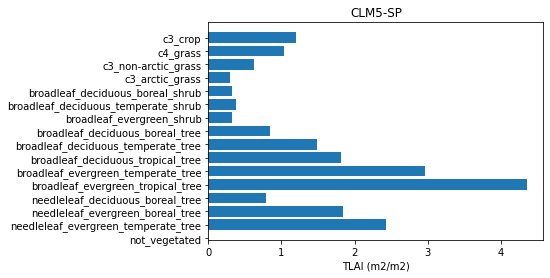

In [30]:
plt.barh(range(16),laipft)
plt.yticks(range(16),pfts[:16])
plt.xlabel('TLAI (m2/m2)')
plt.title('CLM5-SP');

### keith's simulation

In [32]:
#locate the output files
d='/glade/p/cgd/tss/people/oleson/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
tape='h1'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
yr0=1985
files = np.array(files)[yrs>=yr0]
def preprocess(ds):
    dvs=['TLAI','GPP','pfts1d_wtgcell']
    return ds[dvs]
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',
                     parallel=True,
                     preprocess=preprocess)
ds['time']=xr.cftime_range(str(yr0),freq='MS',periods=len(ds.time),calendar='noleap')
tmp=xr.open_dataset(files[0])
for v in tmp.data_vars:
    if 'time' not in tmp[v].dims:
        if 'wtgcell' not in v:
            ds[v]=tmp[v]

In [33]:
t=slice('2003','2014')
lai=ds.TLAI.sel(time=t)
wtg=ds.pfts1d_wtgcell.sel(time=t)

In [43]:
%%time
da=pftgrid(lai,ds)
w=pftgrid(wtg,ds)

CPU times: user 45.3 s, sys: 23.1 s, total: 1min 8s
Wall time: 1min 19s


In [44]:
a=la*w
cf=1/amean(a).sum(dim=['lat','lon'])
x=amean(a*da).sum(dim=['lat','lon'])
laipft2=(x*cf).mean(dim='year')

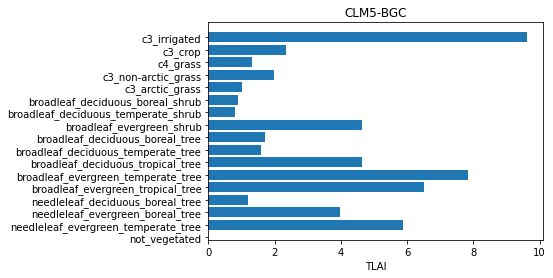

In [48]:
plt.barh(range(17),laipft2)
plt.yticks(range(17),pfts)
plt.xlabel('TLAI')
plt.title('CLM5-BGC');

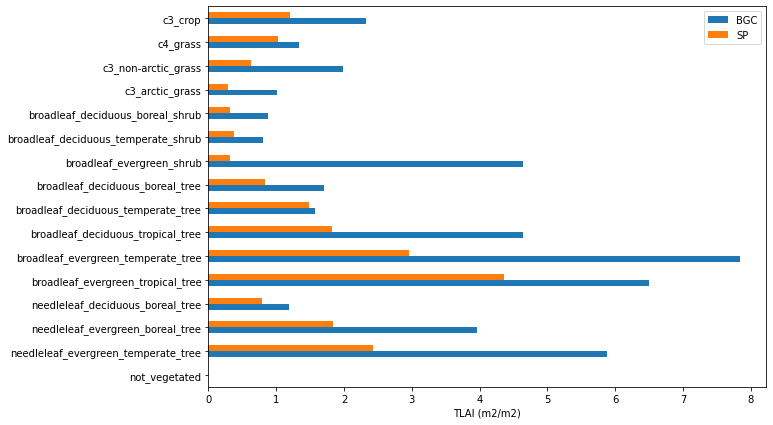

In [68]:
df=pd.DataFrame({'BGC':laipft2[:-1],'SP':laipft})
df.plot(kind='barh',figsize=[10,7]);
plt.xlabel('TLAI (m2/m2)')
plt.yticks(range(16),pfts[:16]);